# Implementation of Quantum Autoencoder and Quantum GAN for MNIST fashion dataset

In this notebook we present the code used for the final project. The notebook is divided in two main sections, one for the quantum autoencoder, and one for the quantum GAN. 

In [1]:
import numpy as np
# Quiskit libraries
# from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
# from qiskit.tools.jupyter import *
# from qiskit.visualization import *
# from qiskit.circuit import Parameter, ParameterVector

#MNIST set libraries for the acquisition and pre-processing data.
# import tensorflow as tf

#Graph libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.transforms import v2

# Library imports
import math
import random
import pandas as pd
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

from PIL import Image
import torchvision.transforms as T
from subprocess import Popen, PIPE
import re


# Auto Encoder


## This section loads and visualizes training set

In [ ]:
#Loading the MNIST set divided by a train set and a test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

#Showing the length of the train and test sets
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))


Number of images in the training set: 60000
Number of images in the test set: 10000


In [ ]:
#Function to filter the labels of the Fashion MNIST set
'''
0 	T-shirt/top
1 	Trouser
2 	Pullover
3 	Dress
4 	Coat
5 	Sandal
6 	Shirt
7 	Sneaker
8 	Bag
9 	Ankle boot

Input = x_label and y_label sets
Output = x_label and y_label sets filtered
'''
def filter_01(x, y):
    keep = (y == 0) | (y == 1) | (y == 2) | (y == 3) | (y == 4) | (y == 5) | (y == 6) | (y == 7) | (y == 8) | (y == 9)
    x, y = x[keep], y[keep]
    return x,y

In [ ]:
x_train, y_train = filter_01(x_train, y_train) #Filter the train set
x_test, y_test = filter_01(x_test, y_test) #Filter the test set


#Showing the length of the train and test sets after filtering the data
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 60000
Number of images in the test set: 10000


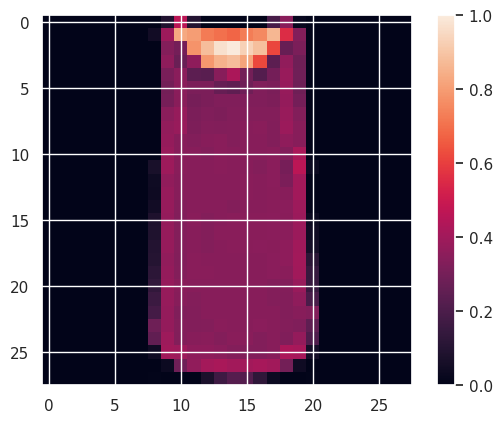

In [ ]:
#Plotting the first element of the train set
plt.imshow(x_train[2])
plt.colorbar()


In [ ]:
#resizing the image from 28x28 to 8x8 by the nearest method
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()


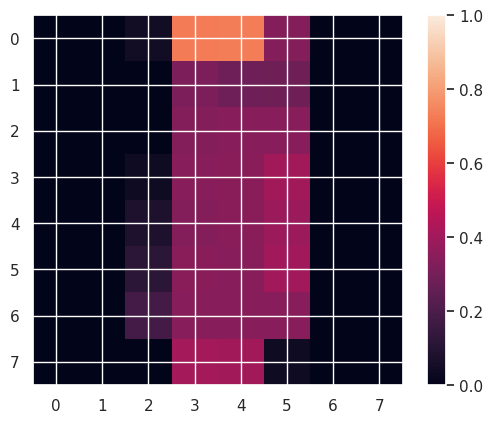

In [ ]:
#Plotting the first element of the train set after the resizing
plt.imshow(x_train_small[2], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
#Deleting no valuable information for the training set
k = 0

while k < len(x_train_small):
    a = x_train_small[k].copy() #make a copy of the actual element
    #Verfify if it has some valuable data
    if np.sum(a) == 0.:
        #If not has valuable data
        print(k,x_train_small[k])
        x_train_small = np.delete(x_train_small, k, axis=0) #Delete the actual element from the x_label
        y_train = np.delete(y_train, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1

<Figure size 640x480 with 0 Axes>

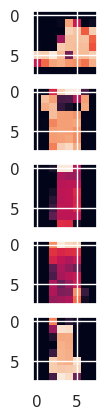

In [ ]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_train_small[0].reshape(8,8)*255)
axarr[1].imshow(x_train_small[1].reshape(8,8)*255)
axarr[2].imshow(x_train_small[2].reshape(8,8)*255)
axarr[3].imshow(x_train_small[3].reshape(8,8)*255)
axarr[4].imshow(x_train_small[4].reshape(8,8)*255)

## this section normalizes data form training set

In [ ]:
#Deleting no valuable information for the test set
k = 0

while k < len(x_test_small): #Deleting no valuable information for the training set
    a = x_test_small[k].copy()
    #Verfify if it has some valuable data
    if np.sum(a) == 0.:
        #If not has valuable data
        print(k,x_test_small[k])
        x_test = np.delete(x_test_small, k, axis=0) #Delete the actual element from the x_label
        y_test = np.delete(y_test, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1


In [ ]:
import cmath
#Funtion to normalize the data of an array
'''
Input = Array with n values
Output = Array with normalized valued
'''
def Normalize(row):
    #We calculate the squareroot of the sum of the square values of the row
    suma = np.sqrt(np.sum(row**2))
    if suma == 0.:
        #If the sum is zero we return a 0
        return 0.0
    #Else we divide each value between the sum value above
    row = row/suma
    return row

#Normalize the training set data
for i in range(len(x_train_small)):
    x_train_small[i] = Normalize(x_train_small[i])

#Normalize the test set data
for i in range(len(x_test_small)):
    x_test_small[i] = Normalize(x_test_small[i])

#Showing the state sum of the training set
print("The sum of the states from the training set 0",np.sum(x_train_small[2]**2))

The sum of the states from the training set 0 1.0000000000000002


## this section defines the quantum components

In [ ]:
n=6 #Number of qubits
num_layers = 1 #Number of layers
#Making a ndarray of floats based on the number of layers
params = np.random.random(10*(num_layers))

In [ ]:
#Showing the normalized values of the first element of the training set
x_train_small[0]

In [ ]:
#Function to create a quantum circuit based on the number of qubit and a
#vector of complex amplitudes to initialize to
'''
Input: Number of qubits, vector of complex amplitudes
Output: Quantum Circuit
'''
def input_data(n,inputs):
    circuit = QuantumCircuit(n,1) #create the quantum circuit with n qubits
    #initialization of the circuit with the vector of amplitudes
    circuit.initialize(inputs,range(0,n,1))
    circuit.barrier() #Draw a barrier
    return circuit

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


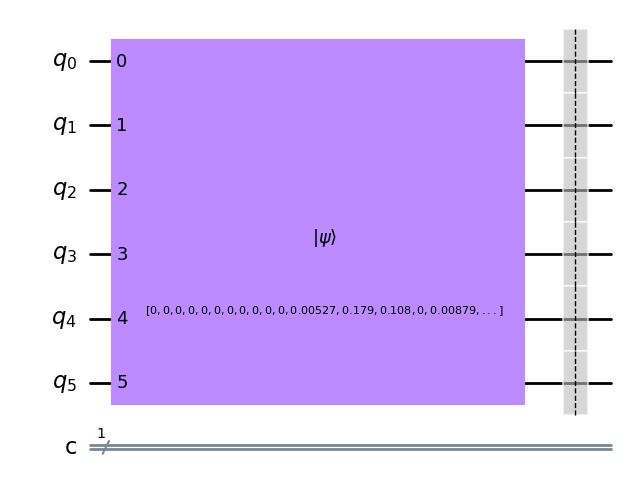

In [ ]:
# Convertir el ndarray a una lista de amplitudes complejas
prueba2 = x_train_small[0].flatten().tolist()

#Example of a quantum circuit with the first row of te trainig set
input_data(n,prueba2).draw(output="mpl")

In [ ]:
#Function to create a quantum variational circuit
'''
Input: number of qubits, number of layers, parameters to initialized the circuit
Output: Quantum Circuit
'''
def vqc(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    parameters = ParameterVector('θ', 10*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n, 1) #create the quantum circuit with n qubits


    #Creating the circuit for each layer
    for layer in range(num_layers):
        #Applying a ry gate in each qubit
        for i in range(n):
            #the rotation of the ry gate is defined in the parameters list
            #based on the layer
            circuit.ry(parameters[(layer)+i], i)
        circuit.barrier() #Create a barrier

        circuit.cx(2,0) #Apply a CNOT gate between the qubit 2 and 0
        circuit.cx(3,1) #Apply a CNOT gate between the qubit 3 and 1
        circuit.cx(5,4) #Apply a CNOT gate between the qubit 5 and 4
        circuit.barrier() #Create a barrier

        #Apply a RY gate in the qubit 0 with the rotation specified in the parameter list
        circuit.ry(parameters[6+(layer)],0)
        #Apply a RY gate in the qubit 1 with the rotation specified in the parameter list
        circuit.ry(parameters[7+(layer)],1)
        #Apply a RY gate in the qubit 4 with the rotation specified in the parameter list
        circuit.ry(parameters[8+(layer)],4)
        circuit.barrier() #Create a barrier

        circuit.cx(4,1) #Apply a CNOT gate between the qubit 4 and 1
        circuit.barrier() #Create a barrier

        #Apply a RY gate in the qubit 1 with the rotation specified in the parameter list
        circuit.ry(parameters[9+(layer)], 1)
        circuit.barrier() #Create a barrier


    #Creating a parameters dictionary
    params_dict = {}
    i = 0
    for p in parameters:
        #The name of the value will be the string identifier and an integer specifying the vector length
        params_dict[p] = params[i]
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit


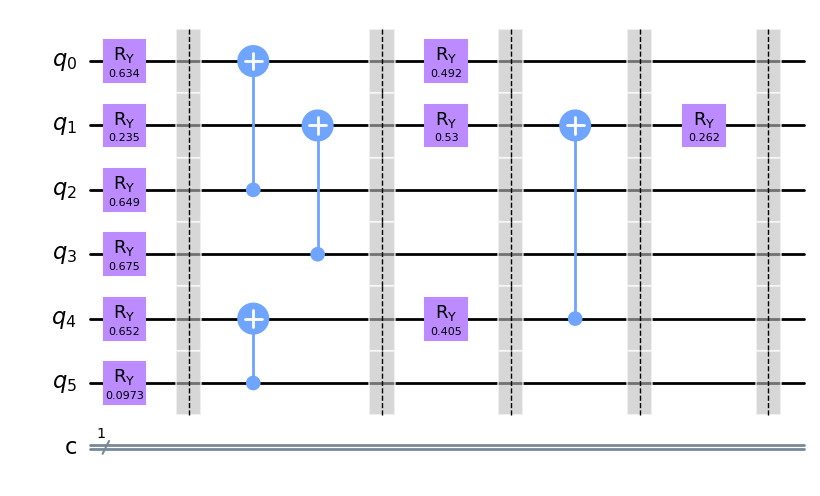

In [ ]:
#An example with 6 quibits, one layer and 10 parameters
vqc(n,num_layers,params).draw(output="mpl")

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


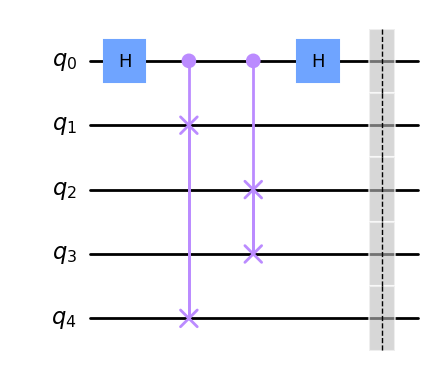

In [ ]:
#Fucntion to make a swap test
'''
Input: Number of qubits
Output: Quantum circuit
'''
def swap_test(n):
    qubits_values = 2*n+1 #Create a new qubit value to create our circuit
    qc = QuantumCircuit(qubits_values) #Create the quantum circuit with the qubits value
    qc.h(0) #Applying a H gate to the first qubit
    for i in range(n):
        #Applying a cswap gate between the first quibit and the i+1 and 2*n-i qubits
        qc.cswap(0,i+1,2*n-i)
    qc.h(0) #Applying a H gate to the first qubit
    qc.barrier() #Create a barrier
    return qc
#Example of a swap test with 2 quibits
swap_test(2).draw(output="mpl")

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


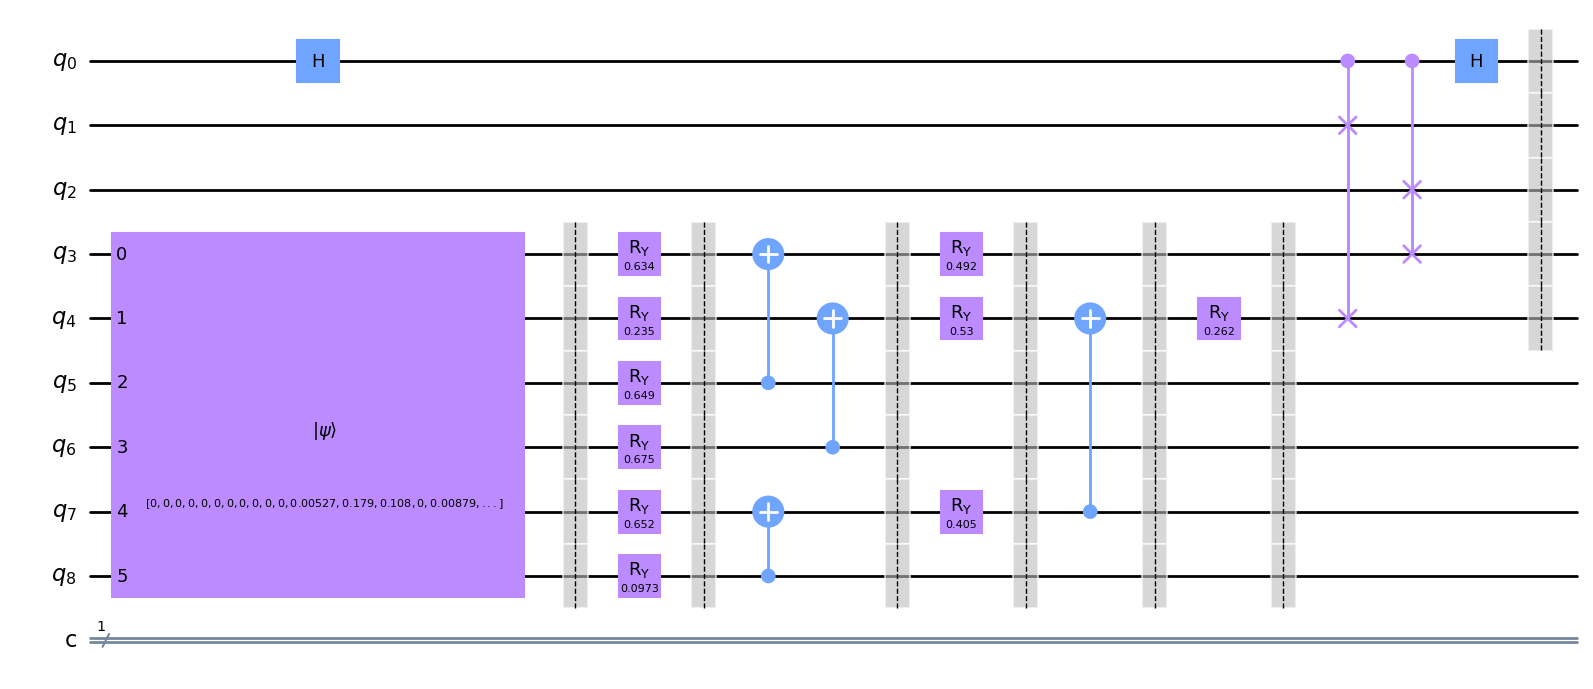

In [ ]:
size_reduce = 2 #Number of qubits we want to reduce
circuit_init = input_data(n,prueba2) #Create a inicial circuit
circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
circuit_swap_test = swap_test(size_reduce) #Create a swap test circuit

#Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
circuit_full = QuantumCircuit(n+size_reduce+1,1)

#Combine the initial circuit, the quantum variatinal circuit and the swap test
#For the initial circuit and QVC we start at the qubit size_reduce + 1
#For the swap test we start at the qubit 0
circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw(output="mpl")

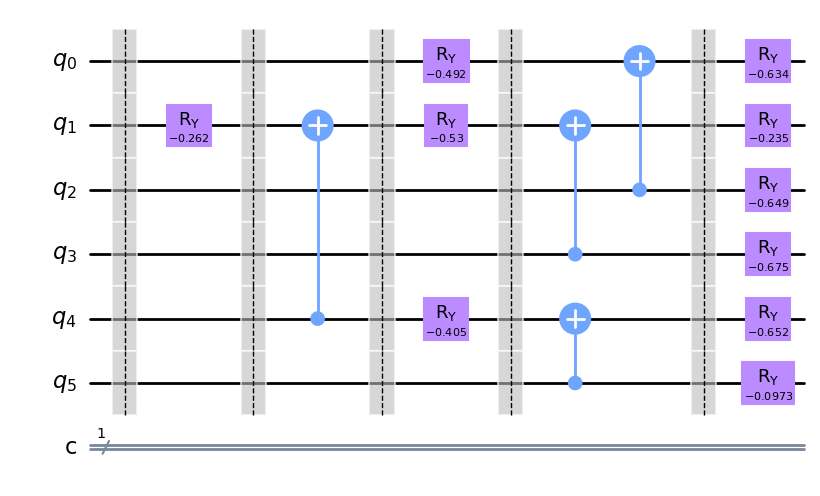

In [ ]:
#We generate the inverse of the QVC
vqc(n,num_layers,params).inverse().draw(output = "mpl")

In [ ]:
from random import shuffle
from scipy.optimize import minimize

In [ ]:
size_reduce = 2 #Number of qubits we want to reduce

In [ ]:
#Function to identify a function cost
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Function cost
'''
def objective_function(params):
    costo = 0
    lenght= 5 #We only will consider the first elements of the taining set
    #For each item of the trainig set
    for i in range(lenght):
        prueba = x_train_small[i].flatten().tolist()
        circuit_init = input_data(n,prueba)#Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
        circuit_swap_test = swap_test(size_reduce) #Create a swap test circuit

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n+size_reduce+1,1)

        #Combine the initial circuit, the quantum variatinal circuit and the swap test
        #For the initial circuit and QVC we start at the qubit size_reduce + 1
        #For the swap test we start at the qubit 0
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        circuit_full.measure(0, 0) #Measure the first qubit
        #qc.draw()
        shots= 8192 #Number of shots
        #Execute the circuit in the qasm_simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=shots )
        counts = job.result().get_counts() #Count the results of the execution
        probs = {} #Calculate the probabilities of 0 and 1 state
        for output in ['0','1']:
            if output in counts:
                probs[output] = counts[output]/shots #Calculate the average of a state
            else:
                probs[output] = 0
        costo += (1 +probs['1'] -  probs['0']) #Update the actual function cost

    return costo/lenght

for i in range(1):
    #Minimization of the objective_fucntion by a COBYLA method
    minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6)
    params = minimum.x #Get the solution array
    #Show the cost of the solution array
    print(" cost: ",objective_function(params))
    print(params)


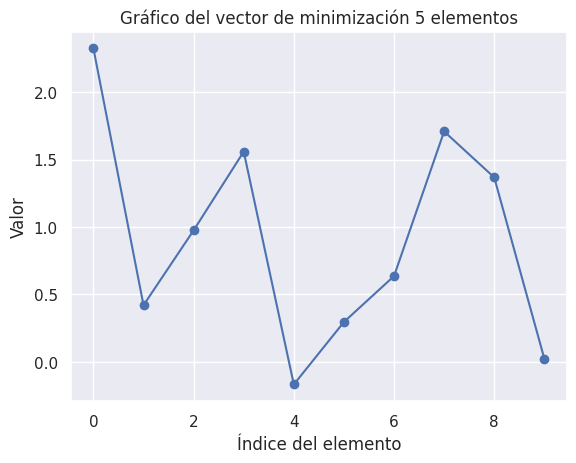

In [83]:
# Crear una figura y un eje (axis)
fig, ax = plt.subplots()

# Graficar el vector como una línea
ax.plot(range(len(params)),params, marker='o', linestyle='-')

# Configurar etiquetas y título
ax.set_xlabel('Índice del elemento')
ax.set_ylabel('Valor')
ax.set_title('Gráfico del vector de minimización 5 elementos')

# Mostrar la gráfica
plt.show()

## this section is the encoder

In [69]:
#Function to compress the training set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result_train(params):
    reduce = [] #List to save the compress values
    #For each row in the training set we will
    for i in range(len(x_train_small)):
        prueba = x_train_small[i].flatten().tolist()
        circuit_init = input_data(n,prueba) #Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n,n-size_reduce)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) #Known the length of the circuit
        #For each n - the the desired qubits to reduce we will
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i) #Measure the circuit in the position size_reduce+i
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts() #Get the results of the execution
        #Get the probabilities of each state
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs) #Save the probabilities

    return reduce

#Call the compress_result_train function with the parameters defined above
reduce_img =compress_result_train(params)
train_reduce = [] #List to save the new values of the image reduction
#for each value in the reduce_img list
for i in reduce_img:
    index_image = [] #List to save the reduction values
    #We now take in count we want a 4X4 image
    for j in range(16):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        while len(bin_index) <4: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0

    #We save the new imagen values in the train_recuce list
    train_reduce.append(np.array(index_image))


<Figure size 640x480 with 0 Axes>

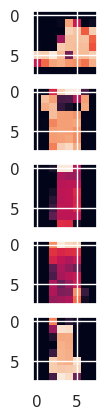

In [ ]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_train_small[0].reshape(8,8)*255)
axarr[1].imshow(x_train_small[1].reshape(8,8)*255)
axarr[2].imshow(x_train_small[2].reshape(8,8)*255)
axarr[3].imshow(x_train_small[3].reshape(8,8)*255)
axarr[4].imshow(x_train_small[4].reshape(8,8)*255)


<Figure size 640x480 with 0 Axes>

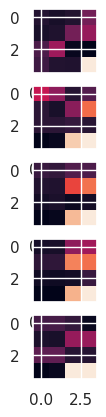

In [70]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_reduce[0].reshape(4,4)*255)
axarr[1].imshow(train_reduce[1].reshape(4,4)*255)
axarr[2].imshow(train_reduce[2].reshape(4,4)*255)
axarr[3].imshow(train_reduce[3].reshape(4,4)*255)
axarr[4].imshow(train_reduce[4].reshape(4,4)*255)

## this section is the decoder

In [71]:
#Function to decode the test set values compressed
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with decode values
'''

def decoder_result_test(params):
    reduce = [] #List to save the decoded values
    #For each row in the test set reduced we will
    for i in range(len(train_reduce)):

        #Create a initial circuit with 6 qubits and a list of 48 zeros and the i row of the test reduced values
        circuit_init = input_data(6,np.concatenate((np.zeros(48), train_reduce[i]), axis=0))
        #Create the inverse VQC
        circuit_vqc = vqc(n,num_layers,params).inverse()

        #Create a new circuit to combine the inicial circuit and the VQC
        circuit_full = QuantumCircuit(n,n)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector() #Get the results of the execution
        reduce.append(result) #Save the results
    return reduce

#Call the decoder_result_test function
decoder =decoder_result_test(params)


<ipython-input-72-a82bfed29237>:7: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
<ipython-input-72-a82bfed29237>:8: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
<ipython-input-72-a82bfed29237>:9: DeprecationWarning: The return type of saved statevectors has bee

<Figure size 640x480 with 0 Axes>

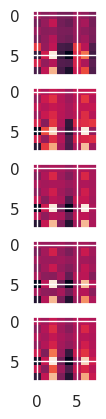

In [72]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
axarr[2].imshow(decoder[2].real.reshape(8,8)*255)
axarr[3].imshow(decoder[3].real.reshape(8,8)*255)
axarr[4].imshow(decoder[4].real.reshape(8,8)*255)

## verifying the results

In [ ]:
#Function to calculate Mean square error
'''
Input: 2 list with the images values
Output: the mean square error
'''
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [ ]:
from skimage.metrics import structural_similarity as ssim

In [73]:
import math
ssim_list = [] #List to save the structural similarity index measure
mse_list = [] #List to save the Mean square error
psnr_list = [] #List to save the Peak signal-to-noise ratio

#For each row of the training set we will
for i in range(len(x_train)):
    #Reshape to a 8X8 image of the training set
    test_img = x_train_small[i].reshape(8,8)*255
    #Reshape to a 8X8 image of the decoded trainig set
    decoded_img = decoder[i].real.reshape(8,8)*255
    #Calculate the MSE between the reshaped decoded image and the trainig set image
    Y = float(mse(decoded_img,test_img))
    #Calculate the SSIM between the reshaped decoded image and the trainig set image
    ssim_list.append(ssim(decoded_img.astype("float"),test_img.astype("float")))
    mse_list.append(Y) #Save the MSE value
    aux = (64**2)/Y #Calculate the PSNR
    psnr_list.append(10*math.log10(aux)) #Save the PSRN value

<ipython-input-73-504e332f0b69>:11: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  decoded_img = decoder[i].real.reshape(8,8)*255


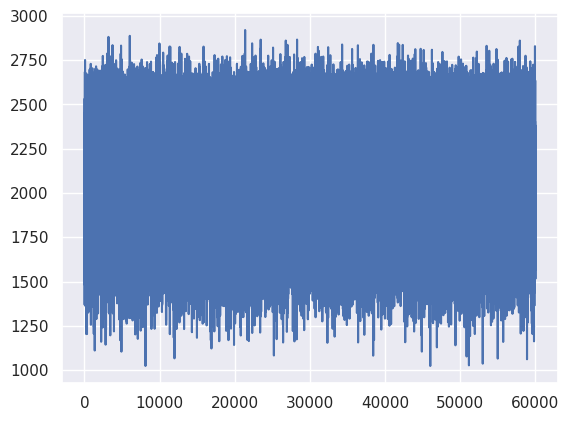

In [74]:
#Plotting the MSE results of the training set
from matplotlib import pyplot as plt
plt.plot(mse_list)
plt.show()

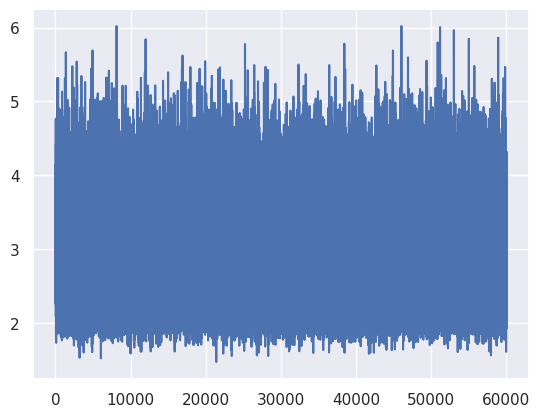

In [75]:
#Plotting the PSNR results of the training set
from matplotlib import pyplot as plt
plt.plot(psnr_list)
plt.show()

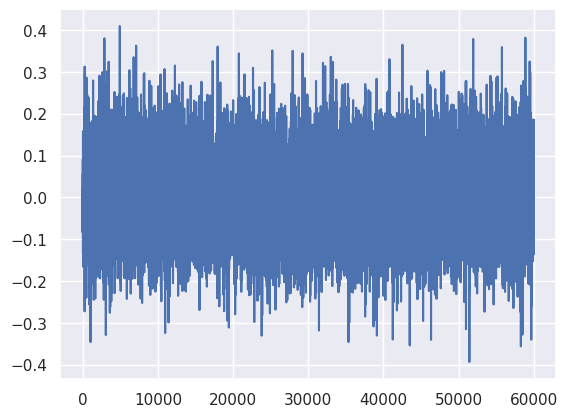

In [76]:
#Plotting the SSIM results of the training set
from matplotlib import pyplot as plt
plt.plot(ssim_list)
plt.show()

# QGAN

## In this section we will visualize the dataset

In [2]:
#open training and test data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# create a dictionary to map items
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
labels_map_inverted = {v: k for k, v in labels_map.items()}

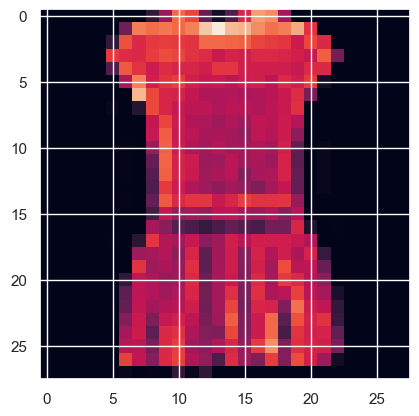

In [3]:
# visualize dataset item
img,label=training_data[3]
lol=img.numpy()
plt.imshow(lol.squeeze());

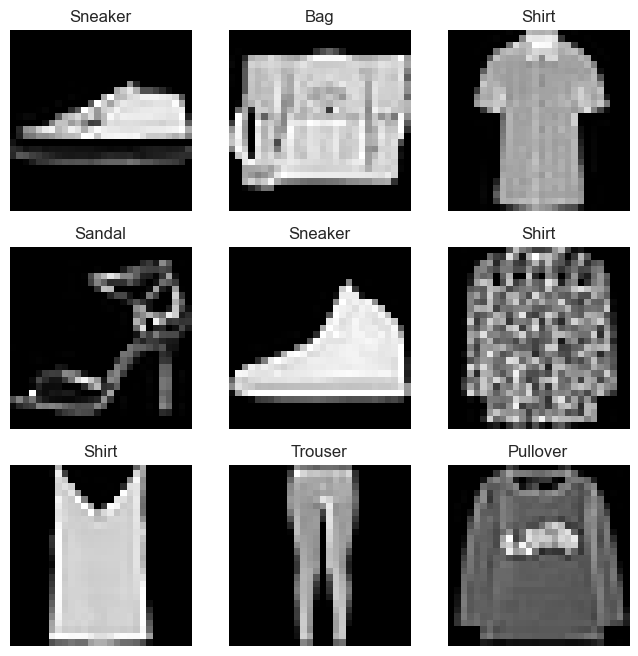

In [4]:
# visualize 
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## In this section we create a class to manage the dataset

In [5]:
class ClothesDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, train_frame, label='T-Shirt', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_frame = train_frame
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = [train for train in training_data if train[-1]==labels_map_inverted[label]]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image,label=self.df[idx]

        if self.transform:
            image = self.transform(image)
        
        # Return image and label
        return image, label

In [6]:
image_size = 28  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = ClothesDataset(train_frame=training_data,label='T-Shirt',transform=v2.Resize(size=(28,28)))
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

## In this section we define the discriminator

In [7]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size,image_size * image_size),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(image_size * image_size, 16),
            nn.ReLU(),
            # nn.Linear(64, 16),
            # nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## In this section the quantum generator

The quantum generator is defined as a quantum circuit, but the model uses a quantum patch, which is a group of quantum generators that together form the complete image

In [9]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 49  # Number of subgenerators for the patch method / N_G

image_size = 28  # Height / width of the square images
batch_size = 1

# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

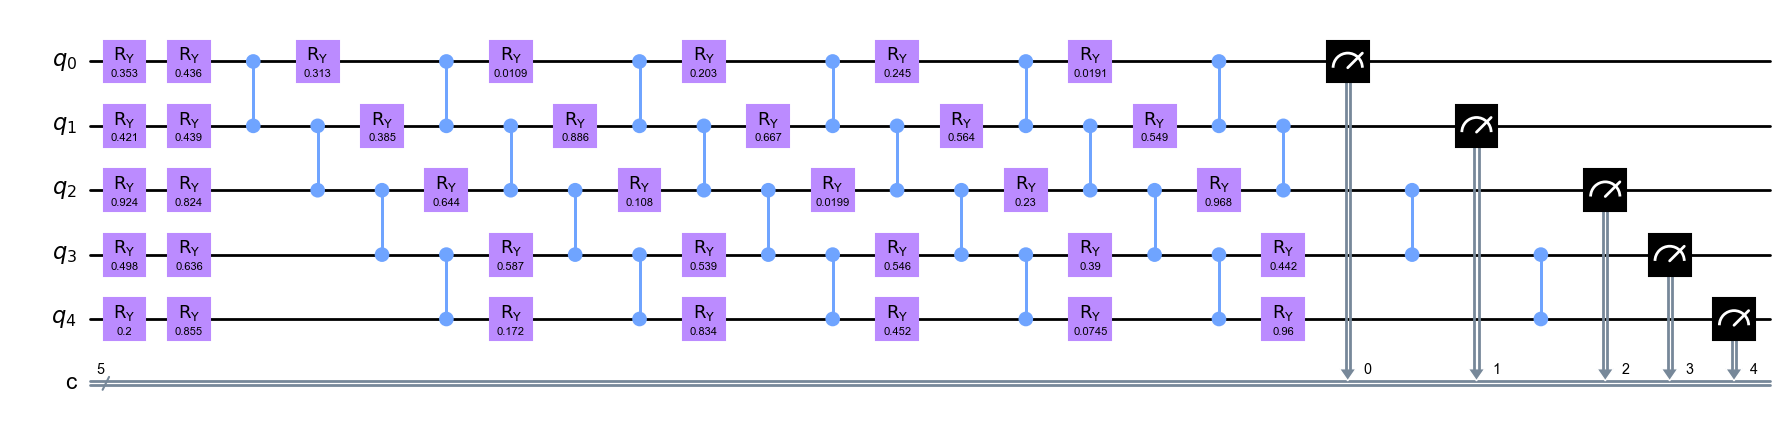

In [43]:

# Quantum simulator
dev = qml.device("qiskit.aer", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise,weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))
# noise

weights = nn.Parameter( 1* torch.rand(q_depth * n_qubits), requires_grad=True)
noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
quantum_circuit(noise[0],weights)
dev._circuit.draw(output="mpl",style="clifford",fold=26)

## This is the training section, where all comes together

In [ ]:
lrG = 0.1  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 600  # Number of training iterations

discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)
# uncomment this section to load saved models in case something went wrong
# checkpoint_gen = torch.load('./data/Experimento 2/Ankle Boot/model/generator/gen_latest.pth')
# generator.load_state_dict(checkpoint_gen)
# checkpoint_dis = torch.load('./data/Experimento 2/Ankle Boot/model/discriminator/dis_latest.pth')
# discriminator.load_state_dict(checkpoint_dis)

# Binary cross entropy
criterion = nn.BCELoss()


# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise_b = torch.rand(200, n_qubits, device=device) * math.pi / 2
fixed_noise_s = torch.rand(8, n_qubits, device=device) * math.pi / 2


# Iteration counter
counter =0

# Collect images and losses for plotting later
results = []
loss_gen = []
loss_dis = []
loss_dis_real = []
loss_dis_fake = []
fid_list = []


In [ ]:
# train while counter<max_iters
while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1
        loss_gen.append(errG)
        loss_dis.append(errD)
        loss_dis_real.append(errD_real)
        loss_dis_fake.append(errD_fake)


        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            torch.save(discriminator.state_dict(), './data/model/discriminator/dis_latest.pth')
            torch.save(generator.state_dict(), './data/model/generator/gen_latest.pth')

            # Save images every 50 iterations
            if counter % 50 == 0:
                test_images_bunch = generator(fixed_noise_b).view(200,1,image_size,image_size).cpu().detach()
                smaller_bunch = generator(fixed_noise_s).view(8,1,image_size,image_size).cpu().detach()
                results.append(smaller_bunch)
                #calculate fid every 50 iterations
                for j, im in enumerate(test_images_bunch):
                    np_arr = im.numpy()
                    transform=T.ToPILImage()
                    imt=transform(im)
                    imt.save(f"./data/generated_fid/{j}.png")
                    
                stdout = Popen('python -m pytorch_fid ./data/generated_fid ./data/original_data/T-Shirt-28', shell=True, stdout=PIPE).stdout
                output = stdout.read()
                fid =float(re.findall('[0-9]+\.[0-9]+',str(output))[0])
                fid_list.append(fid)


        if counter == num_iter:
            break
    if counter == num_iter:
        break

## This section is for visualizing and saving the results

### visualizing generated images

In [ ]:
#visualize the saved images, 8 every 50 iters
fig = plt.figure(figsize=(17, 5))
outer = gridspec.GridSpec(6, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        # if j==0:
        #     ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

In [ ]:
# run this cell to save the generated images
from PIL import Image
import torchvision.transforms as T
for i, images in enumerate(results):
    images = torch.squeeze(images, dim=1)    
    for j, im in enumerate(images):
        np_arr = im.numpy()
        transform=T.ToPILImage()
        imt=transform(im)
        imt.save(f"./data/generated/{j}-{(i+1)*50}.png")
        # imt.show()

### visualizing losses and fid

In [ ]:

list_loss_gen = [loss_gen[i].detach().numpy().tolist() for i in range(len(loss_gen))]
list_loss_dis = [loss_dis[i].detach().numpy().tolist() for i in range(len(loss_dis))]

plt.plot(list_loss_gen,label='generator')
plt.plot(list_loss_dis,color='red',label='discriminator')
plt.ylabel('loss')
plt.xlabel('iter')
plt.legend()

In [ ]:
plt.plot(fid_list,label='fid')

### save losses and fid 

In [ ]:
name = ['fid','discriminator','discriminator_real','discriminator_fake','generator']
lists = [fid_list,loss_dis,loss_dis_real,loss_dis_fake,loss_gen]
for i in name
with open(r'./data/{name}.txt'.format(name=name), 'w') as fp:
    for item in lists[name.index(i)]:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')